In [1]:
import tensorflow as tf
import pandas as pd
import yfinance as yf
import numpy as np
import math
from itertools import product, combinations
from sklearn.preprocessing import MinMaxScaler
from copy import copy
from collections import deque
from tqdm.auto import tqdm

In [2]:
class PortfolioEnv():
    def __init__(self, dates, datasets, n):
        self.dates = dates
        self.datasets = datasets
        self.n = n
        self.process_big_pt()
        
        self.process_small_pt()
        
        self.initial_pt = 1000000 # 1 000 000
        self.c_minus = 0.0025 # 0.25%
        self.c_plus = 0.0025 # 0.25%
        self.delta = 10000 # 10 000
                
        self.process_actions()
        self.action_shape = self.actions.shape[0]
        self._episode_ended = False
    
    def reset(self):
        # initialisation of portfolio
        self.pt = self.initial_pt # 1 000 000
        self.wt = [0.25,0.25,0.25,0.25] # wt before state 0
        
        self.current_tick = 0 # after checking, current_tick should be set to 0
        self.episode_ended = False
        
        ktc = self.big_pt[self.current_tick,0,:,self.n-1] # nouveaux close prices des différents assets
        wt_prime = (self.wt*self.phi(ktc)) / (np.dot(self.wt,self.phi(ktc))) # nouvelles proportions des assets du portfolio
        
        # after checking, we should return state 0
        return {'big_xt':np.array(self.small_pt[self.current_tick]), 'wt_prime':wt_prime}
    
    def process_actions(self):
        asset_number = 3
        action_number = 3

        seq = np.arange(asset_number)
        actions = []

        for c in product(seq, repeat=action_number):
            actions.append(c)

        self.actions = np.array(actions)
    
    def find_action_index(self,action):
        for ind, a in enumerate(self.actions):
            if np.array_equal(a, action):
                return ind;
    
    def process_big_pt(self):
        datasets = self.datasets
        date_start = self.dates[0]
        date_end = self.dates[1]

        dfs = []
        for d in datasets:
            ticker = yf.Ticker(d)
            # get historical market data
            df_ = ticker.history(start=date_start, end=date_end, interval="1d")    
            df_.rename(mapper={
                "Close": d+"_close",
                "Open": d+"_open",
                "High": d+"_high",
                "Low": d+"_low",
                "Volume": d+"_volume"
            }, inplace=True, axis=1)
            if "Dividends" in df_.columns:
                df_.drop(axis=1,labels=["Dividends", "Stock Splits"],inplace=True)
            dfs.append(df_)

        final_df = pd.concat(dfs, axis=1)
        final_df.dropna(inplace=True)
        
        self.final_df = final_df
        
        final_df = self.final_df
        n = self.n
        Pc = []
        for d in datasets:
            asset_close = final_df[d+"_close"].values
            asset_prev_close = final_df[d+"_close"].shift().values
            Kc = (asset_close - asset_prev_close) / asset_prev_close
            Kc = Kc[1:]
            Pc_ = [Kc[i:i+n] for i in range(len(asset_close)-n)] # Kc[0:20], Kc[1:21], Kc[2:22]
            Pc.append(Pc_)
        Pc = np.array(Pc)
        Po = []
        for d in datasets:
            asset_prev_close = final_df[d+"_close"].shift().values
            asset_open = final_df[d+"_open"].values
            Ko = (asset_open - asset_prev_close) / asset_prev_close
            Ko = Ko[1:]
            Po_ = [Ko[i:i+n] for i in range(len(asset_open)-n)]
            Po.append(Po_)
        Po = np.array(Po)
        Pl = []
        for d in datasets:
            asset_close = final_df[d+"_close"].values
            asset_low = final_df[d+"_low"].values
            Kl = (asset_close - asset_low) / asset_low
            Kl = Kl[1:]
            Pl_ = [Kl[i:i+n] for i in range(len(asset_low)-n)]
            Pl.append(Pl_)
        Pl = np.array(Pl)
        Ph = []
        for d in datasets:
            asset_close = final_df[d+"_close"].values
            asset_high = final_df[d+"_high"].values
            Kh = (asset_close - asset_high) / asset_high
            Kh = Kh[1:]
            Ph_ = [Kh[i:i+n] for i in range(len(asset_high)-n)]
            Ph.append(Ph_)
        Ph = np.array(Ph)
        Pv = []
        for d in datasets:
            asset_prev_volume = final_df[d+"_volume"].shift().values
            asset_volume = final_df[d+"_volume"].values
            Kv = (asset_volume - asset_prev_volume) / asset_prev_volume
            Kv = Kv[1:]
            Pv_ = [Kv[i:i+n] for i in range(len(asset_high)-n)]
            Pv.append(Pv_)
        Pv = np.array(Pv)
        Pt_star = np.array([Pc, Po, Pl, Ph, Pv])

        self.big_pt = Pt_star.swapaxes(0,2).swapaxes(1,2)
        print(self.big_pt.shape)
        
    def process_small_pt(self):
        small_pt = []
        
        for big_xt in self.big_pt:
            big_xt = big_xt.swapaxes(0,1).swapaxes(1,2)
            big_xt_scaled = np.array([mm_scaler.fit_transform(a) for a in big_xt])

            small_pt.append(big_xt_scaled)
        
        self.small_pt = np.array(small_pt)
        print(self.small_pt.shape)
    
    def phi(self,v):
        return np.insert(v, 0, [0]) + np.ones(len(v) + 1)
    
    def get_wt_prime_chapeau(self,wt_prime,big_s_minus,big_s_plus,pt_prime):
        wt_prime_chapeau = []
        for ind, key in enumerate(wt_prime):
            if(ind in big_s_minus):
                wt_prime_chapeau.append(key - self.delta/pt_prime)
            elif(ind in big_s_plus):
                wt_prime_chapeau.append(key + self.delta/pt_prime)
            else:
                wt_prime_chapeau.append(key)
    
        return np.array(wt_prime_chapeau)
    
    def is_asset_shortage(self,action,pt,wt):
        big_s_minus = np.where(action==0)[0]
        for ind in big_s_minus:
            if wt[ind+1]*pt < self.delta:
                return True
        
        return False
    
    #alright
    def is_cash_shortage(self,action,pt,wt):
        big_s_minus = np.where(action==0)[0]
        big_s_plus = np.where(action==2)[0]
        current_cash = wt[0]*pt
        cash_after_selling = current_cash + (1-self.c_minus)*self.delta*len(big_s_minus) # must include transaction costs
        cash_needed = (self.c_plus+1)*self.delta*len(big_s_plus) # must include transaction costs
        
        if(cash_after_selling < cash_needed):
            return True
        
        return False
    
    def action_mapping(self,action,action_Q_values,pt,wt):
        action = copy(action)
        action_mapped = action
        if self.is_asset_shortage(action,pt,wt):
            action_mapped = self.rule2(action,action_Q_values,pt,wt)
        elif self.is_cash_shortage(action,pt,wt):
            action_mapped = self.rule1(action,action_Q_values,pt,wt)
        
        return action_mapped
    
    def rule1(self,action,action_Q_values,pt,wt):
        MAXQ = np.NINF
        action_selected = action
        
        big_s_plus = np.where(action==2)[0]
        
        for i in range(1,len(big_s_plus) + 1):
            for c in combinations(big_s_plus, i):
                new_action = copy(action)
                for j in c:
                    new_action[j] = 1

                if not self.is_cash_shortage(new_action,pt,wt):
                    new_action_index = self.find_action_index(new_action)
                    new_action_Q_value = action_Q_values[new_action_index]
                    
                    if new_action_Q_value > MAXQ:
                        MAXQ = new_action_Q_value
                        action_selected = new_action
        
        return action_selected
    
    def rule2(self,action,action_Q_values,pt,wt):
        for i in range(len(action)):
            if wt[i+1]*pt < self.delta:
                action[i] = 1
        
        if self.is_cash_shortage(action,pt,wt):
            action = self.rule1(action,action_Q_values,pt,wt)
        
        return action
    
    def F(self,pt,wt):
        action_possible = []
        for ind, action in enumerate(self.actions):
            if not self.is_asset_shortage(action,pt,wt) and not self.is_cash_shortage(action,pt,wt):
                action_possible.append(ind)

        return np.array(action_possible)
    
    def step(self, action, simulation=False):
        # Must set new portfolio with regards to action
        # Must set new reward
        if self.current_tick == len(self.big_pt) - 2:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            self.episode_ended = True
        
        # we are in state 0, best action between state 0 and state 1 has been predicted
        # so we must get portfolio value and weights after state 0 evolution
        # but before action has been taken into account
        ktc = self.big_pt[self.current_tick,0,:,self.n-1] # nouveaux close prices des différents assets
        pt_prime = self.pt * np.dot(self.wt,self.phi(ktc)) # nouvelle valeur du portfolio issue de l'action précédente
        wt_prime = (self.wt*self.phi(ktc)) / (np.dot(self.wt,self.phi(ktc))) # nouvelles proportions des assets du portfolio
        
        # On prend en compte la nouvelle action
        big_s_minus = np.where(action==0)[0]
        big_s_plus = np.where(action==2)[0]
        
        ct = (self.delta*(self.c_minus*len(big_s_minus) + self.c_plus*len(big_s_plus)))/pt_prime
        if not simulation:
            self.pt = pt_prime*(1 - ct)
        else:
            pt = pt_prime*(1 - ct)
        
        wt_prime_chapeau_1tillend = self.get_wt_prime_chapeau(wt_prime[1:],big_s_minus,big_s_plus,pt_prime)
        wt_prime_chapeau_0 = wt_prime[0] + self.delta*((1-self.c_minus)*len(big_s_minus)-(1+self.c_plus)*len(big_s_plus))/pt_prime
        wt_prime_chapeau = np.concatenate((np.array([wt_prime_chapeau_0]), wt_prime_chapeau_1tillend))
        
        # now we evolve to state one, to get reward of this action
        if not simulation:
            self.wt = wt_prime_chapeau / (np.dot(wt_prime_chapeau, np.ones(len(wt_prime_chapeau))))
            self.current_tick += 1
            k_t_plus_one_c = self.big_pt[self.current_tick,0,:,self.n-1]
        else:
            wt = wt_prime_chapeau / (np.dot(wt_prime_chapeau, np.ones(len(wt_prime_chapeau))))
            current_tick = self.current_tick + 1
            k_t_plus_one_c = self.big_pt[current_tick,0,:,self.n-1]
        
        big_p_s_t_plus_one = pt_prime*np.dot(wt_prime, self.phi(k_t_plus_one_c))
        
        if not simulation:
            p_t_plus_one_prime = self.pt * np.dot(self.wt,self.phi(k_t_plus_one_c))
            reward = (p_t_plus_one_prime - big_p_s_t_plus_one)/big_p_s_t_plus_one
            wt_plus_one_prime = (self.wt*self.phi(k_t_plus_one_c)) / (np.dot(self.wt,self.phi(k_t_plus_one_c)))
        else:
            p_t_plus_one_prime = pt * np.dot(wt,self.phi(k_t_plus_one_c))
            reward = (p_t_plus_one_prime - big_p_s_t_plus_one)/big_p_s_t_plus_one
            wt_plus_one_prime = (wt*self.phi(k_t_plus_one_c)) / (np.dot(wt,self.phi(k_t_plus_one_c)))
        
        if not simulation:
            return {'big_xt':np.array(self.small_pt[self.current_tick]), 'wt_prime':wt_plus_one_prime}, reward, self.episode_ended
        else:
            return {'big_xt':np.array(self.small_pt[current_tick]), 'wt_prime':wt_plus_one_prime}, reward, self.episode_ended, p_t_plus_one_prime, wt_plus_one_prime
        

In [3]:
mm_scaler = MinMaxScaler()

datasets = ["SPY", "IWD", "IWC"]
train_dates = ["2006-01-01", "2017-12-30"] # let's train it on more datas to see what happens
n = 20
env = PortfolioEnv(train_dates, datasets, n)
datas_ = env.big_pt
datas = datas_.swapaxes(2,3).swapaxes(1,3)
final_datas = []
for d in datas:
    final_datas.append(d[0])
    final_datas.append(d[1])
    final_datas.append(d[2])
final_datas = np.array(final_datas)
datas_scaled = np.array([mm_scaler.fit_transform(d) for d in final_datas]) # MinMaxScaler par ligne ou par colonne ?
X_train = datas_scaled[:7200]
X_valid = datas_scaled[7200:]

(3000, 5, 3, 20)
(3000, 3, 20, 5)


In [5]:
recurrent_encoder = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=128, input_shape=[20,5], return_sequences=True),
    tf.keras.layers.LSTM(units=20),
])
recurrent_decoder = tf.keras.models.Sequential([
    tf.keras.layers.RepeatVector(20, input_shape=[20]),
    tf.keras.layers.LSTM(units=20, return_sequences=True),
    tf.keras.layers.LSTM(units=128, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5, activation="sigmoid"))
])
recurrent_ae = tf.keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(optimizer='adam', loss='binary_crossentropy')
recurrent_encoder.summary()
recurrent_decoder.summary()
recurrent_ae.summary()

history = recurrent_ae.fit(X_train, X_train, epochs=50, validation_data=(X_valid, X_valid))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 128)           68608     
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                11920     
Total params: 80,528
Trainable params: 80,528
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_1 (RepeatVecto (None, 20, 20)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 128)           76288     
____________________________

In [6]:
test_samples = len(X_valid)
len(np.arange(0, test_samples, 190))

10

In [7]:
def plot_examples(stock_input, stock_decoded, j):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 190))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx,:,j])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx,:,j],color='green')
        ax.get_xaxis().set_visible(False)

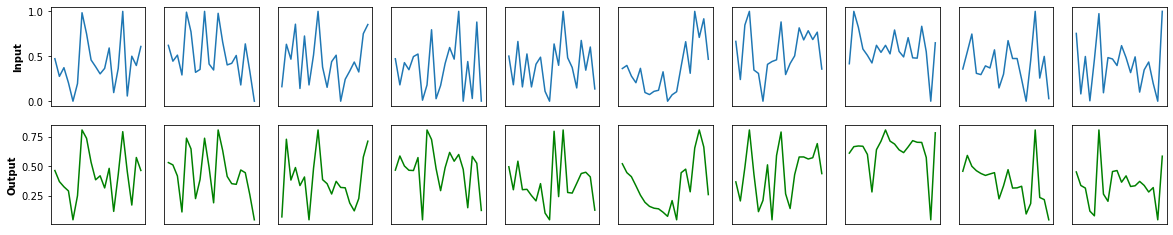

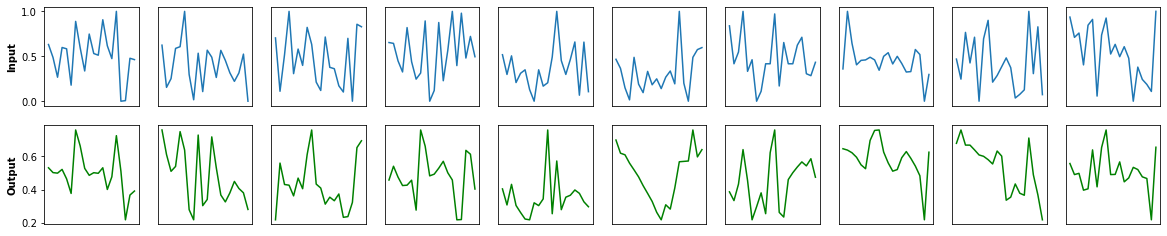

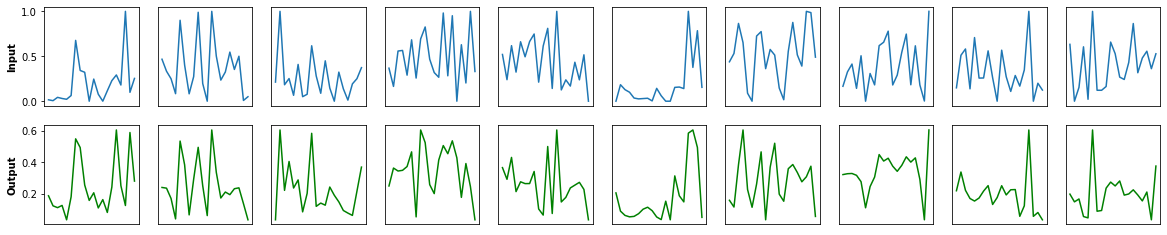

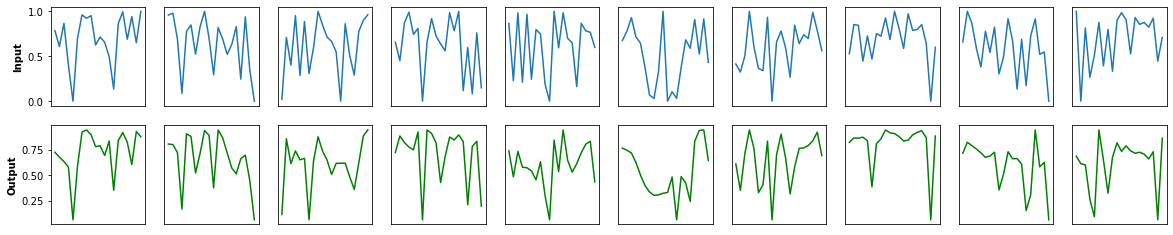

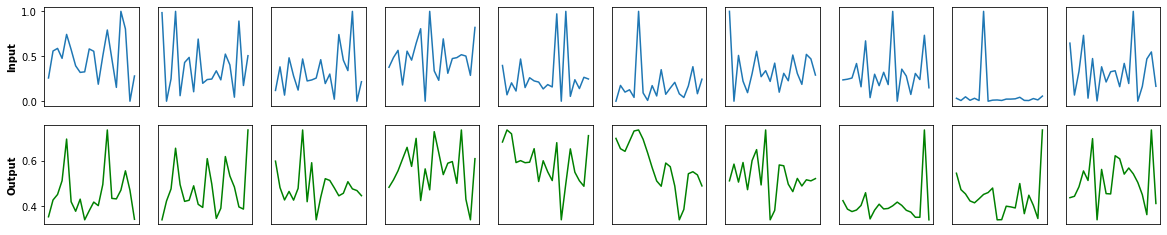

In [8]:
import matplotlib.pyplot as plt
decoded_stocks = recurrent_ae.predict(X_valid)
plot_examples(X_valid, decoded_stocks, 0)
plot_examples(X_valid, decoded_stocks, 1)
plot_examples(X_valid, decoded_stocks, 2)
plot_examples(X_valid, decoded_stocks, 3)
plot_examples(X_valid, decoded_stocks, 4)